## Imports

In [1]:
import pandas_datareader.data as web
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import opstrat as op
from scipy.stats import norm

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# Stock Analysis

In [2]:
ticker = "AAPL"
beta = 1.27
stock = yf.Ticker(ticker)
latest_price = stock.history(period='1d')['Close'][0]
price = round(latest_price, 2) 

input = "^TNX"
output = yf.Ticker(input)
latest_price2 = output.history(period='1d')['Close'][0]
rate = round(latest_price2, 2) 

input2 = "^VIX"
output2 = yf.Ticker(input2)
latest_price3 = output2.history(period='1d')['Close'][0]
vol = round(latest_price3, 2) 

print (ticker,"Price:",price)
print ("Rate:",rate)
print ("Vol:",vol)

St = price
K = price
r = rate
T = 87
v= (vol*beta)

call=op.black_scholes(K=K, St=St, r=r, t=T, v=v, type='c')
print('3M ATM Call Price:',(call['value']['option value']))

put=op.black_scholes(K=K, St=St, r=r, t=T, v=v, type='p')
print('3M ATM Put Price:',(put['value']['option value']))

AAPL Price: 137.87
Rate: 3.47
Vol: 19.38
3M ATM Call Price: 7.161412169340295
3M ATM Put Price: 6.025797848742336


# Portfolio Construction

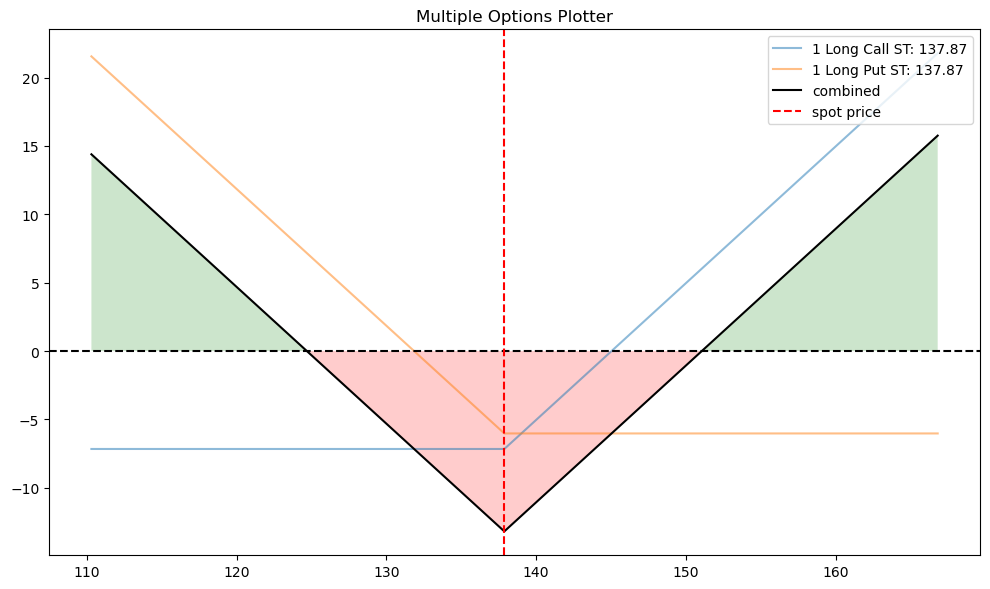

In [3]:
op_1 = {'op_type':'c','strike':price,'tr_type':'b','op_pr':(call['value']['option value'])}
op_2 = {'op_type':'p','strike':price,'tr_type':'b','op_pr':(put['value']['option value'])}
op.multi_plotter(spot=price, op_list=[op_1,op_2])

## The Greeks

In [4]:
print('Call Delta is:',call['greeks']['delta'])
print('Put Delta is:',put['greeks']['delta'])

Call Delta is: 0.551286621821818
Put Delta is: -0.4487133781781821


In [5]:
print('Call Theta is:',call['greeks']['theta'])
print('Put Theta is:',put['greeks']['theta'])

Call Theta is: -0.04421468063713203
Put Theta is: -0.031215548628706676


# Risk Assessment

## Monte Carlo Simulation

[*********************100%***********************]  1 of 1 completed


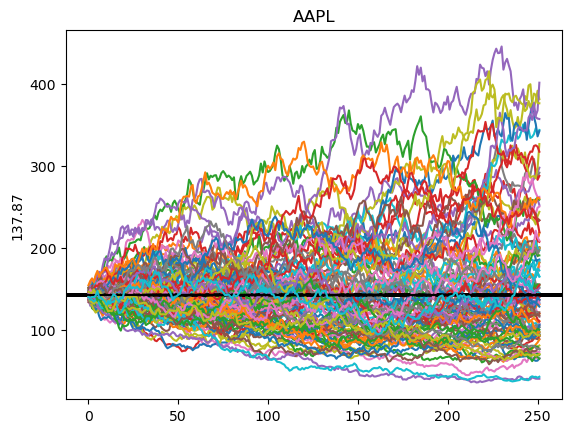

In [6]:
df = yf.download(ticker)
returns = np.log(1+df['Adj Close'].pct_change())
mu, sigma = returns.mean(), returns.std()
sim_rets = np.random.normal(mu,sigma,252)
initial = df['Adj Close'].iloc[-1]
sim_prices = initial * (sim_rets + 1).cumprod()

for _ in range(100):
    sim_rets = np.random.normal(mu,sigma,252)
    sim_prices = initial * (sim_rets + 1).cumprod()
    plt.axhline(initial,c='k')
    plt.plot(sim_prices)
    plt.ylabel(price)
    plt.grid()
    plt.title(ticker)